# ARMA task
Learn an autoregressive moving average model (see Wikipedia for an introduction if unfamiliar) for at least 5 individual sensors (pick them in a sensible way!). Most statistical packages (R, statsmodels in Python) contain standard algorithm for fitting these models from training data. Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using Akaike’s Information Criterion (AIC) or another model selection method. Note that there exists a wide range of ARMA variants; you only have to use the basic model.

Decide how to set the detection threshold sensibly. Study some of the anomalies detected anomalies. What kind of anomalies can you detect using ARMA models? Which sensors can be modeled effectively using ARMA?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [2]:
def parse_date(x):    
    date = str(x).split(' ')[0]
    time_stamp = pd.datetime.strptime(date,'%d/%m/%y')
    return time_stamp
df_1 = pd.read_csv('BATADAL_dataset_training_1.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_2 = pd.read_csv('BATADAL_dataset_training_2.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_3 = pd.read_csv('BATADAL_test_dataset.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_1.head()

tank_features = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7']

## Check autocorrelation
Apply Durbin Watson test to examine autocorrelation in the data. The test will return a value between 0 and 4.
- A value of 2.0 means there is no autocorrelation detected in the sample. 
- Values from zero to 2.0 indicate positive autocorrelation.
- Values from 2.0 to 4.0 indicate negative autocorrelation.

In [ ]:
for feature in tank_features:
    print(sm.stats.durbin_watson(df_1[feature]))

## Identifying the order of differencing(d) in ARIMA model

In [ ]:
for feature in tank_features:
    result = adfuller(df_1[feature].dropna())
    print('FEATURE: %s, ADF Statistic: %f, p-value: %f ' % (feature, result[0], result[1]))

## Diagnosing ACF and PACF plots

In [ ]:
def plot_acf_pacf(feature_name):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df_1[feature_name], lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(df_1[feature_name], lags=40, ax=ax2)
    fig.suptitle(feature_name, fontsize="large")
    plt.savefig("fig/acf/" + feature_name)
    plt.show()

for feature in tank_features:
    plot_acf_pacf(feature)

### Apply ARIMA

In [6]:
# Grid search to find optimal parameter for ARMA model
def grid_search(feature):
    f = open("log/grid_search.txt", "a")
    f.write("-------- " + feature + "---------\n")
    print("---------- FEATURE: " + feature + " ---------\n")

    best_order = None
    best_score = float('Inf')
    for p in range(0, 4):
        for d in range(0, 2):
            for q in range(0, 2):
                order = (p, d, q)
                try:
                    model = ARIMA(df_1[feature], order=order)
                    model_fit = model.fit(disp=0, trend='nc')
                    aic = model_fit.aic
#                     print('ARIMA%s AIC=%.3f' % (order,aic))
                    f.write('ARIMA%s AIC=%.3f\n' % (order,aic))
                    
                    # Select model with low aic score
                    if (aic < best_score):
                        best_order = order
                        best_score = aic
                except:
                    continue
    
    print('Best ARIMA%s AIC=%.3f' % (best_order, best_score))
    f.write('Best ARIMA%s AIC=%.3f\n' % (best_order, best_score))
    f.close()
    return best_order

In [18]:
# Predict singal value
def predict(coef, arr):
    yhat = 0.0
    for i in range(1, len(coef) + 1):
        yhat += coef[i - 1] * arr[-i]
#         print("arr[-%d]=%f" % (i, arr[-i]))
    return yhat

# Concatenate list
def prepare(preset, history):
    for i in range(len(preset)):
        history.append(preset[i])
    return history

# Get the threshold from training data
def train_threshold(train, history, p, ar_coef, ma_coef, residuals, feature):   
    prediction = list()
    
    for i in range(p, len(train)+p):
        yhat = predict(ar_coef, history) + predict(ma_coef, residuals) + history[-1]
        observed = train[i]
        history.append(observed)
        error = abs(yhat-observed)
        residuals.append(error)
        prediction.append(yhat)
#         print('predicted=%.3f, observed=%.3f, previous=%.3f, residual=%.3f' % (yhat, observed, history[-2], error))

    
    # Plot prediction vs actual
    plt.figure(figsize=(15,2))
    plt.plot(prediction, label='prediction')
    plt.plot(train, label='actual')
    plt.legend()
    plt.title("ARMA prediction of " + feature)
    plt.savefig("fig/prediction/" + feature)
    plt.show()
    
    threshold = max(residuals) * 1
    return threshold

def predict_anomaly(threshold, history, test, p, ar_coef, ma_coef, residuals, feature):  
    anomaly, prediction = list(), list()
    
    for i in range(p, len(test)+p):
        yhat = predict(ar_coef, history) + predict(ma_coef, residuals) + history[-1]
        observed = test[i]
        history.append(observed)
        error = abs(yhat-observed)
        residuals.append(error)
        prediction.append(yhat)
#         print('predicted=%.3f, observed=%.3f, previous=%.3f, residual=%.3f' % (yhat, observed, history[-2], error))
        
        if error > threshold:
            anomaly.append(i)
            print('DETECTED residual=%.3f at t=%d' % (error, i))
    
    f = open("log/detection.txt", "a")
    f.write("Feature: %s, threshold: %.3f\n" % (feature, threshold))
    f.write(" ".join(str(x) for x in anomaly) + "\n\n")
    f.close()
    
    print(anomaly)

---------- FEATURE: L_T1 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(3, 1, 1) AIC=-13224.471


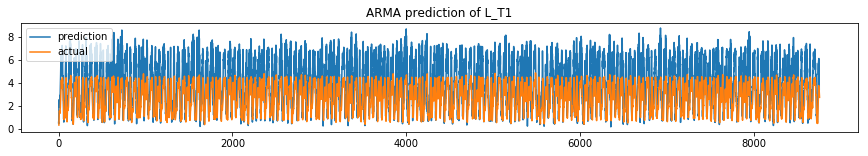

DETECTED residual=4.441 at t=945
[945]
---------- FEATURE: L_T2 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(3, 1, 1) AIC=-175.408


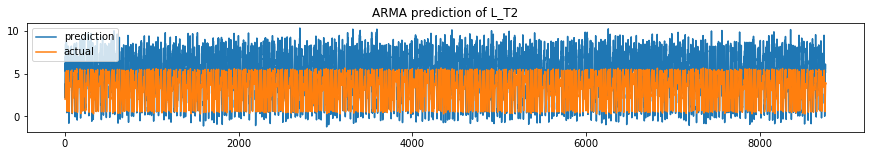

DETECTED residual=6.628 at t=1229
DETECTED residual=5.302 at t=1252
DETECTED residual=7.135 at t=1253
DETECTED residual=6.628 at t=1277
DETECTED residual=5.302 at t=1300
DETECTED residual=7.135 at t=1301
DETECTED residual=6.628 at t=1325
[1229, 1252, 1253, 1277, 1300, 1301, 1325]
---------- FEATURE: L_T3 ---------

Best ARIMA(3, 1, 0) AIC=-216.990


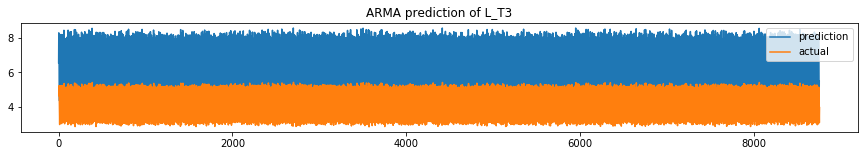

[]
---------- FEATURE: L_T4 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value enc

Best ARIMA(3, 1, 1) AIC=8248.333


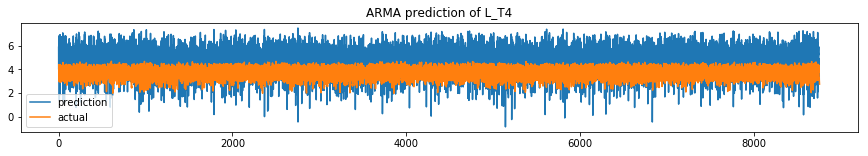

[]
---------- FEATURE: L_T5 ---------

Best ARIMA(3, 1, 0) AIC=5136.421


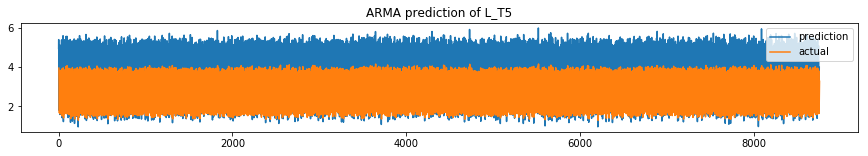

[]
---------- FEATURE: L_T6 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(2, 1, 1) AIC=-12202.193


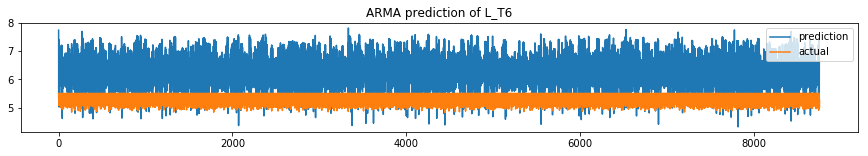

[]
---------- FEATURE: L_T7 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(3, 1, 1) AIC=14094.889


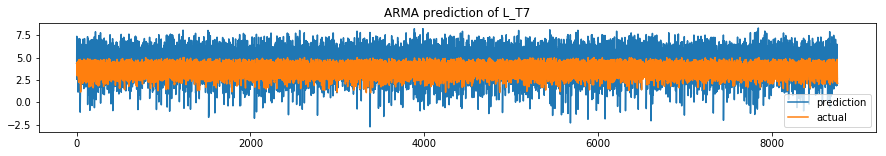

[]


In [19]:
def pipeline():
    for feature in tank_features:
        training_data = df_1[feature]
        testing_data = df_3[feature]
        
        # Fina best parameter for ARMA
        order = grid_search(feature)
        p = order[0]
        
        # Build ARMA model
        model = ARIMA(df_1[feature], order=order)
        model_fit = model.fit(disp=0)
        ar_coef = model_fit.arparams
        ma_coef = model_fit.maparams
        residuals = model_fit.resid.tolist()
        
        # Get threshold from training data
        pretrain, train = training_data[0:p], training_data[p:]
        history = prepare(pretrain.tolist(), training_data.tolist())
        threshold = train_threshold(train, history, p, ar_coef, ma_coef, residuals, feature)
        
        # Test anomaly on testing set
        pretest, test = testing_data[0:p], testing_data[p:]
        history = prepare(pretest.tolist(), history)
        predict_anomaly(threshold, history, test, p, ar_coef, ma_coef, residuals, feature)
        

pipeline()
        